# want: 
place field infos
place field across trials
change point in trials
change point in times, with metrics and labels
everything: left, right, both



In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'

import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [2]:
import template

In [2]:
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0

In [15]:
db.shape

(72, 12)

In [29]:
reload(dpp)

<module 'data_prep_pyn' from '/mnt/home/szheng/projects/util_code/data_prep_pyn.py'>

In [2]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0] #0

# data_dir_full = db.query('sess_name=="e15_9f1_200723"')['data_dir_full'][0]

# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses='*SessionPulses.Events.mat')
# sessionPulses=mat_to_return['sessionPulses']
# filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']
# ripples = mat_to_return['ripples']
# cell_metrics = mat_to_return['cell_metrics']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
# prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=True,extra_load=dict(sessionPulses='*SessionPulses.Events.mat',filtered='*thetaFiltered.lfp.mat'))
spk_beh_df=prep_res['spk_beh_df']
_,spk_beh_df = dpp.group_into_trialtype(spk_beh_df)
# spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,nbins=100)
spk_beh_df,_=dpp.add_lin_binned(spk_beh_df,bin_size=2.2,nbins=None)
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df']
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)
spike_trains = prep_res['spike_trains']


/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


load *SessionPulses.Events.mat failed


In [3]:
import behavior_analysis as ba
reload(ba)

<module 'behavior_analysis' from '/mnt/home/szheng/projects/place_variability/code/behavior_analysis.py'>

In [209]:
reload(dpp)

<module 'data_prep_pyn' from '/mnt/home/szheng/projects/util_code/data_prep_pyn.py'>

In [4]:
corners_d,xy_sampled_d,segment_d=dpp.find_tmaze_turns(beh_df,n_lin=200,speed_key='speed_kalman',speed_thresh=10)



In [5]:
reload(dpp)
beh_df = dpp.get_v_kalman_and_aligned(beh_df)

In [6]:
v_thresh = 3
dist_off_thresh = 6

# sub_beh_df = copy.copy(beh_df[['x','y','v_kalman_aligned','v_kalman_off','coord_off','lin']].dropna(axis=0))
sub_beh_df = copy.copy(beh_df.loc[beh_df[['v_kalman_aligned']].notna().values])
sub_beh_df['dist_off'] = sub_beh_df['coord_off'].abs()
sub_beh_df['is_running'] = (sub_beh_df['v_kalman_aligned'] >=v_thresh)&(sub_beh_df['dist_off']<=dist_off_thresh)




In [7]:
def test_scan(dist_off,v_off,dist_off_buffer,v_off_buffer,dist_off_thresh=5):
    
    def iqr_test(x,x_l):
        l = np.quantile(x_l,0.25)
        u = np.quantile(x_l,0.75)
        d = l-u
        isin = (l - d/2)<= x <= (u + d/2)
        sig = not isin
        return sig
    
    isoff = dist_off > dist_off_thresh
    sig_dist_off = iqr_test(dist_off,dist_off_buffer)
    sig_v_off = iqr_test(v_off,v_off_buffer)
    sig = isoff|sig_dist_off|sig_v_off
    
    return sig

In [26]:
sub_beh_df

,x,y,v_kalman_aligned,v_kalman_off,coord_off,lin,dist_off,is_running
Time (s),,,,,,,,
7865.562433,86.148757,43.909340,1.462491,2.211043,3.633360,0.000000,3.633360,False
7865.595767,86.148757,43.909340,1.649800,2.083475,3.633360,0.000000,3.633360,False
7865.629100,86.148757,43.909340,1.762247,1.968043,3.633360,0.000000,3.633360,False
7865.662433,86.148757,43.909340,1.820734,1.862245,3.633361,0.000000,3.633361,False
7865.695800,86.067164,44.147695,1.955296,1.724947,3.551767,221.736358,3.551767,False
...,...,...,...,...,...,...,...,...
10017.539300,91.759619,49.629031,0.819338,0.175316,9.244223,215.848359,9.244223,False
10017.572633,91.444089,49.966782,1.219387,0.003587,8.928693,215.496837,8.928693,False
10017.605967,91.139881,50.283213,1.633119,-0.265843,8.624485,215.233195,8.624485,False


In [8]:
%%time
dt = np.median(np.diff(sub_beh_df.index))
sub_beh_df = sub_beh_df.reset_index()
buffer_time = 4.
n_buffer = int(buffer_time / dt)
is_putative_scan_d = {}
for i in range(n_buffer,sub_beh_df.shape[0]):
    if not sub_beh_df['is_running'].values[i]:
        dist_off = sub_beh_df['dist_off'].values[i]
        v_off = sub_beh_df['v_kalman_off'].values[i]
        
        buffer = sub_beh_df.iloc[i-n_buffer:i]
        v_off_buffer = buffer['v_kalman_off']
        dist_off_buffer = buffer['dist_off']
        is_putative_scan = test_scan(dist_off,v_off,dist_off_buffer,v_off_buffer,dist_off_thresh=dist_off_thresh)
        is_putative_scan_d[sub_beh_df.index[i]] = is_putative_scan
is_putative_scan_df = pd.Series(is_putative_scan_d)

CPU times: user 16.4 s, sys: 0 ns, total: 16.4 s
Wall time: 16.4 s


In [9]:
def get_contiguous_blocks(x):
    x_diff = np.diff(x)
    jumps=np.nonzero(x_diff!=1)[0] # corresponding to the end of each chunk
    jumps = np.append(jumps,len(x)-1)
    jumps = np.insert(jumps,0,-1)
#     jumps = jumps + 1 # corresponding to the start of each chunk
    starts = jumps[:-1]+1
    ends = jumps[1:]
    block_slices = np.stack([x[starts],x[ends]],axis=1) # time point indices, start and end of a block, both sides included in the block
#     block_slices = np.stack([starts,ends],axis=1)
    return block_slices
    

In [10]:
merge_gap_thresh = 0.4
n_merge_gap_thresh = int(merge_gap_thresh / dt)

In [11]:
block_slices=get_contiguous_blocks(is_putative_scan_df.loc[is_putative_scan_df].index)

In [12]:
# merge block slices
block_slices_merged = [block_slices[0]]
ind_in_merged = 0
for i in range(block_slices.shape[0]-1):
    if (block_slices[i+1][0] - block_slices_merged[ind_in_merged][1]) <= n_merge_gap_thresh:
        block_slices_merged[ind_in_merged] =np.array([block_slices_merged[ind_in_merged][0],block_slices[i+1][1]]) # update in merged
    else:
        block_slices_merged.append(block_slices[i+1])
        ind_in_merged =ind_in_merged+1
        
block_slices_merged=np.array(block_slices_merged)

In [13]:
duration_thresh=0.4
n_duration_thresh = int(duration_thresh/dt)
ma = np.diff(block_slices_merged,axis=1).squeeze() > n_duration_thresh
block_slices_merged_long=block_slices_merged[ma]

In [14]:
lin_diff_within_block_thresh = 10.
lin_diff_within_block = sub_beh_df.loc[block_slices_merged_long[:,1],'lin'].values - sub_beh_df.loc[block_slices_merged_long[:,0],'lin'].values
ma=lin_diff_within_block<=lin_diff_within_block_thresh
block_slices_merged_long_stationary = block_slices_merged_long[ma]



In [15]:
radial_extent_thresh = 2.5
radial_extent_l = []
for i in range(block_slices_merged_long_stationary.shape[0]):
    st,ed=block_slices_merged_long_stationary[i]
    radial_extent = np.abs(sub_beh_df.loc[st:ed,'coord_off'] - sub_beh_df.loc[st,'coord_off']).max()
    radial_extent_l.append(radial_extent)
radial_extent_l = np.array(radial_extent_l)
ma = radial_extent_l > radial_extent_thresh
block_slices_merged_long_stationary_radial = block_slices_merged_long_stationary[ma]

In [16]:
is_head_scan = np.zeros(sub_beh_df.shape[0])*np.nan
for ii,sl in enumerate(block_slices_merged_long_stationary_radial):
    is_head_scan[sl[0]:(sl[1]+1)] = ii
sub_beh_df['is_head_scan'] = is_head_scan

In [240]:
sub_beh_df.query('lin>50&lin<80')['is_head_scan'].unique()

array([nan,  7., 37.])

In [241]:
one_chunk=sub_beh_df.query('is_head_scan==37')

In [242]:
import matplotlib.cm as cm

In [100]:
np.nonzero(block_slices[:,0]==30422)
block_slices[263]
block_slices[264]
block_slices[265]

array([31257, 31260])

In [102]:
one_chunk

,Time (s),x,y,v_kalman_aligned,v_kalman_off,v,coord_off,lin,dist_off,is_running,is_head_scan
30422,8930.231300,10.709535,10.741832,2.701870,4.803378,-1.426156,-0.241656,110.579049,0.241656,False,30.0
30423,8930.264633,10.751383,10.748364,2.359862,4.819618,-1.835532,-0.199808,110.579049,0.199808,False,30.0
30424,8930.298000,10.781926,10.753130,2.034324,4.837113,-1.816785,-0.169266,111.400911,0.169266,False,30.0
30425,8930.331333,10.817377,10.784374,1.711945,4.856417,-1.846475,-0.133814,111.492088,0.133814,False,30.0
30426,8930.364667,10.864698,10.808993,1.399289,4.881269,-1.951948,-0.086493,111.492088,0.086493,False,30.0
...,...,...,...,...,...,...,...,...,...,...,...
31212,8956.571300,39.311894,44.247623,-0.313526,-1.193132,0.391959,-0.194229,42.516449,0.194229,False,30.0
31213,8956.604633,38.762711,43.869690,0.427918,-1.495375,1.131533,-0.572161,43.048722,0.572161,False,30.0
31214,8956.637967,38.336012,43.489788,1.190762,-1.876462,1.897662,-0.952064,43.492283,0.952064,False,30.0
31215,8956.671333,37.934351,43.152582,1.947574,-2.288111,2.673589,-1.289270,43.935844,1.289270,False,30.0


<AxesSubplot:>

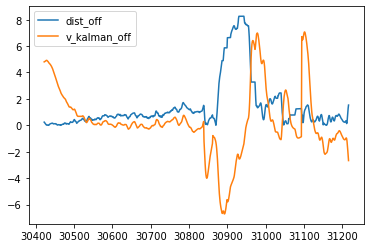

In [103]:
one_chunk[['dist_off','v_kalman_off']].plot()

<AxesSubplot:>

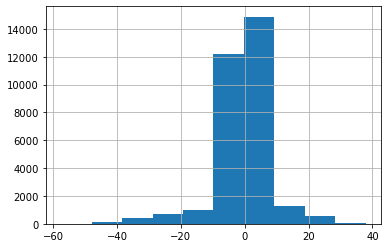

In [133]:
# sub_beh_df.loc[sub_beh_df['is_running']]['dist_off'].hist()
sub_beh_df.loc[sub_beh_df['is_running']]['v_kalman_off'].hist()

In [137]:
corners_d

{(0,
  0.0):            x          y         lin
 0  82.994717  45.576905    0.000000
 1   8.726685  45.576905   73.606170
 2   8.726685  83.605281  111.523984
 3  82.994717  83.605281  184.013924
 4  82.994717  45.576905  221.931738,
 (0,
  1.0):            x          y         lin
 0  82.515396  44.441851    0.000000
 1  10.951191  44.441851   73.606170
 2  10.951191   8.578035  112.639214
 3  82.515396   8.578035  185.129154
 4  82.515396  44.441851  221.931738}

In [174]:
inds=sub_beh_df.loc[sub_beh_df['is_running']&(sub_beh_df['v_kalman_off']>10)].index


In [176]:
inds

Int64Index([  630,   631,   632,   633,   634,   635,   636,   637,   638,
              639,
            ...
            63884, 63885, 63886, 63887, 63888, 63889, 63890, 63891, 63892,
            63893],
           dtype='int64', length=1730)

In [187]:
one_chunk=sub_beh_df.loc[inds[0:20]]

In [190]:
one_chunk

,Time (s),x,y,v_kalman_aligned,v_kalman_off,coord_off,lin,dist_off,is_running,is_head_scan
630,7886.567733,80.696088,12.500500,3.160369,15.380388,-1.819309,187.851256,1.819309,True,NaN
631,7886.601067,81.015717,13.062328,3.548870,15.105332,-1.499679,188.406916,1.499679,True,NaN
632,7886.634400,81.185747,13.817091,4.143014,14.745554,-1.329650,189.240406,1.329650,True,NaN
633,7886.667767,81.331585,14.568995,4.873631,14.318574,-1.183811,190.073896,1.183811,True,NaN
634,7886.701100,81.411037,15.267349,5.666174,13.817146,-1.104360,190.814776,1.104360,True,NaN
635,7886.734433,81.457037,15.862147,6.443441,13.252877,-1.058360,191.463046,1.058360,True,NaN
636,7886.767767,81.506665,16.414458,7.180675,12.652503,-1.008731,192.111316,1.008731,True,NaN
637,7886.801133,81.506241,16.955390,7.875820,12.009404,-1.009156,192.666976,1.009156,True,NaN
638,7886.834467,81.477049,17.415087,8.494190,11.329691,-1.038347,193.130026,1.038347,True,NaN
639,7886.867800,81.485860,17.726415,8.979852,10.650260,-1.029537,193.500466,1.029537,True,NaN


In [244]:
sub_beh_df['ax_kalman'],

0        0.880634
1        0.795027
2        0.717597
3        0.646831
4        0.560167
           ...   
64571   -0.137062
64572   -0.228254
64573   -0.371089
64574   -0.521366
64575   -0.621650
Name: ax_kalman, Length: 64576, dtype: float64

In [248]:
one_chunk.shape

(685, 27)

In [350]:
beh_df = dpp.get_multi_maze_behavior_df(behavior,transition_cov_scale=100000000.)
beh_df[['vx_raw','vy_raw']] = beh_df[['x','y']].diff() / 0.033
sub_beh_df = copy.copy(beh_df).reset_index()

In [299]:
xy=np.stack([behavior.position.x,behavior.position.y],axis=1)

In [317]:
reload(dpp)

<module 'data_prep_pyn' from '/mnt/home/szheng/projects/util_code/data_prep_pyn.py'>

In [352]:
# xy_smth_small_cov = dpp.get_speed_kalman(xy,dt=0.033,order=2,transition_cov_scale=0.1)
xy_smth_big_cov = dpp.get_speed_kalman(xy,dt=0.033,order=1,transition_cov_scale=100000000.)

In [318]:
xy_smth_small_ob = dpp.get_speed_kalman(xy,dt=0.033,order=2,transition_cov_scale=0.1)

In [304]:
np.isclose(xy_smth_small_cov,xy_smth_big_cov)

array([[ True,  True,  True,  True,  True,  True],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       ...,
       [False, False, False, False, False, False],
       [False, False, False, False, False, False],
       [False, False, False, False, False, False]])

In [345]:
sub_beh_df.query('trial==1')

,Time (s),lin,x,y,trial,task_index,task,speed_kalman,vx_kalman,vy_kalman,ax_kalman,ay_kalman,visitedArm,correct,v,trial_type,vx_raw,vy_raw
905,7888.401533,0.000000,81.470195,44.099539,1.0,0,alternation,19.659357,18.437048,6.823898,1.864454,1.119948,0.0,1.0,NaN,"(0, 0.0)",-7.430365,16.902619
906,7888.434867,221.648478,81.128609,44.557781,1.0,0,alternation,19.644362,18.367877,6.965778,1.844389,1.135923,0.0,1.0,NaN,"(0, 0.0)",-10.351084,13.886134
907,7888.468200,221.209075,80.735494,44.961188,1.0,0,alternation,19.626268,18.294236,7.107131,1.823743,1.151736,0.0,1.0,NaN,"(0, 0.0)",-11.912594,12.224459
908,7888.501533,220.857552,80.299868,45.335111,1.0,0,alternation,19.604844,18.215926,7.247752,1.802489,1.167356,0.0,1.0,NaN,"(0, 0.0)",-13.200789,11.330979
909,7888.534900,220.506030,79.844112,45.730067,1.0,0,alternation,19.580119,18.132896,7.387767,1.780622,1.182804,0.0,1.0,NaN,"(0, 0.0)",-13.810777,11.968380
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1631,7912.607633,217.166568,81.465862,48.851741,1.0,0,alternation,19.535846,18.563684,-6.085961,1.763440,-0.786370,0.0,1.0,NaN,"(0, 0.0)",-7.402501,-23.005508
1632,7912.640967,218.045374,81.203664,48.029443,1.0,0,alternation,19.502834,18.488181,-6.208679,1.742919,-0.801118,0.0,1.0,NaN,"(0, 0.0)",-7.945412,-24.918123
1633,7912.674333,218.924180,80.841820,47.196655,1.0,0,alternation,19.467645,18.408432,-6.333942,1.721854,-0.816179,0.0,1.0,NaN,"(0, 0.0)",-10.964955,-25.236005
1634,7912.707667,219.802985,80.312064,46.361479,1.0,0,alternation,19.429397,18.323423,-6.461706,1.700093,-0.831546,0.0,1.0,NaN,"(0, 0.0)",-16.053205,-25.308354


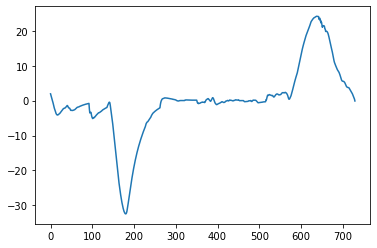

In [353]:
# plt.plot(xy_smth_small_cov[:,2][905:1635])
plt.plot(xy_smth_big_cov[:,2][905:1635])
# plt.plot(xy_smth_small_ob[:,2][905:1635])

<AxesSubplot:xlabel='Time (s)'>

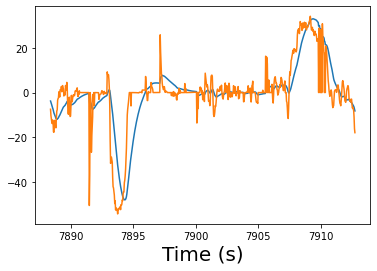

In [351]:
beh_df.query('trial==1')['vx_kalman'].plot()
beh_df.query('trial==1')['vx_raw'].plot()

<AxesSubplot:xlabel='Time (s)'>

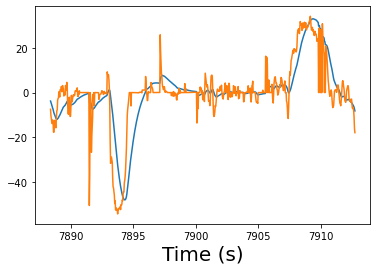

In [290]:
beh_df.query('trial==1')['vx_kalman'].plot()
beh_df.query('trial==1')['vx_raw'].plot()

<AxesSubplot:>

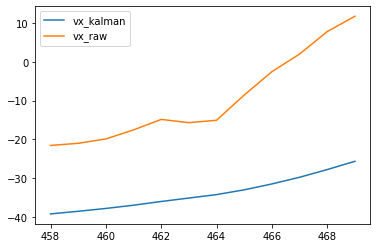

In [292]:
one_chunk[['vx_kalman','vx_raw']].plot()

In [354]:
onechunk_kalman = dpp.get_speed_kalman(one_chunk[['x','y']].values,transition_cov_scale=1000.,order=2)
vx=onechunk_kalman[:,2]
vy=onechunk_kalman[:,3]

In [359]:
vy

array([ 0.00000000e+00,  3.18533861e-06, -2.39153193e-04, -1.24151059e-02,
       -4.17523990e-02, -1.04749334e-01, -2.07703020e-01, -3.50422520e-01,
       -5.22626975e-01, -7.14940062e-01, -9.14028598e-01, -1.09168346e+00])

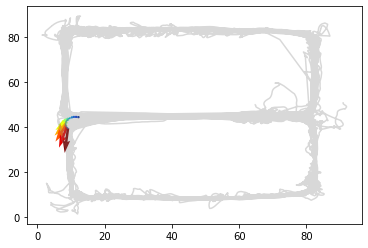

In [365]:
%matplotlib inline
fig,ax=plt.subplots()
ax.plot(sub_beh_df['x'],sub_beh_df['y'],color='grey',alpha=0.3)
# one_chunk =sub_beh_df.query('trial==0').iloc[::5]
one_chunk =sub_beh_df.loc[458:469]
ax.plot(one_chunk['x'],one_chunk['y'],alpha=0.5)
colors = np.arange(one_chunk.shape[0])
cmap = plt.get_cmap('jet')
norm = plt.Normalize(min(colors), max(colors))
ax.quiver(one_chunk['x'],one_chunk['y'],vx,vy,colors,angles='xy',scale_units='xy',scale=0.1,
          cmap=cmap,norm=norm
         )

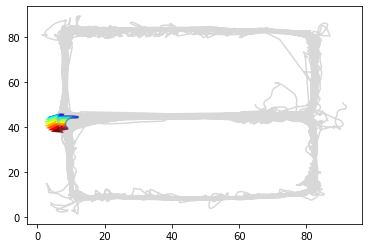

In [286]:
%matplotlib inline
fig,ax=plt.subplots()
ax.plot(sub_beh_df['x'],sub_beh_df['y'],color='grey',alpha=0.3)
# one_chunk =sub_beh_df.query('trial==0').iloc[::5]
one_chunk =sub_beh_df.loc[458:469]
ax.plot(one_chunk['x'],one_chunk['y'],alpha=0.5)
colors = np.arange(one_chunk.shape[0])
cmap = plt.get_cmap('jet')
norm = plt.Normalize(min(colors), max(colors))
ax.quiver(one_chunk['x'],one_chunk['y'],one_chunk['vx_kalman'],one_chunk['vy_kalman'],colors,angles='xy',scale_units='xy',scale=5,
          cmap=cmap,norm=norm
         )

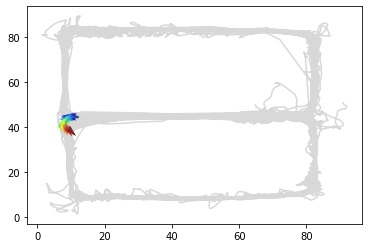

In [284]:
%matplotlib inline
fig,ax=plt.subplots()
ax.plot(sub_beh_df['x'],sub_beh_df['y'],color='grey',alpha=0.3)
# one_chunk =sub_beh_df.query('trial==0').iloc[::5]
one_chunk =sub_beh_df.loc[458:469]
ax.plot(one_chunk['x'],one_chunk['y'],alpha=0.5)
colors = np.arange(one_chunk.shape[0])
cmap = plt.get_cmap('jet')
norm = plt.Normalize(min(colors), max(colors))
ax.quiver(one_chunk['x'],one_chunk['y'],one_chunk['vx_raw'],one_chunk['vy_raw'],colors,angles='xy',scale_units='xy',scale=5,
          cmap=cmap,norm=norm
         )

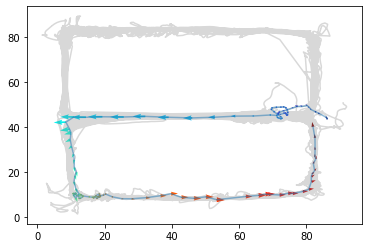

In [261]:
%matplotlib inline
fig,ax=plt.subplots()
ax.plot(sub_beh_df['x'],sub_beh_df['y'],color='grey',alpha=0.3)
one_chunk =sub_beh_df.query('trial==0').iloc[::5]
ax.plot(one_chunk['x'],one_chunk['y'],alpha=0.5)
colors = np.arange(one_chunk.shape[0])
cmap = plt.get_cmap('jet')
norm = plt.Normalize(min(colors), max(colors))
ax.quiver(one_chunk['x'],one_chunk['y'],one_chunk['vx_kalman'],one_chunk['vy_kalman'],colors,angles='xy',scale_units='xy',scale=10,
          cmap=cmap,norm=norm
         )

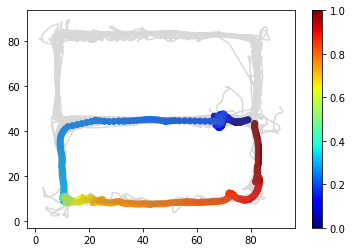

In [368]:
reload(ba)

fig,ax=ba.plot_one_headscan(sub_beh_df,sub_beh_df.query('trial==2'))

In [198]:
trial_l = beh_df_full_reindex['trial']

In [204]:
data_dir_full

'/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913'

<IPython.core.display.Javascript object>


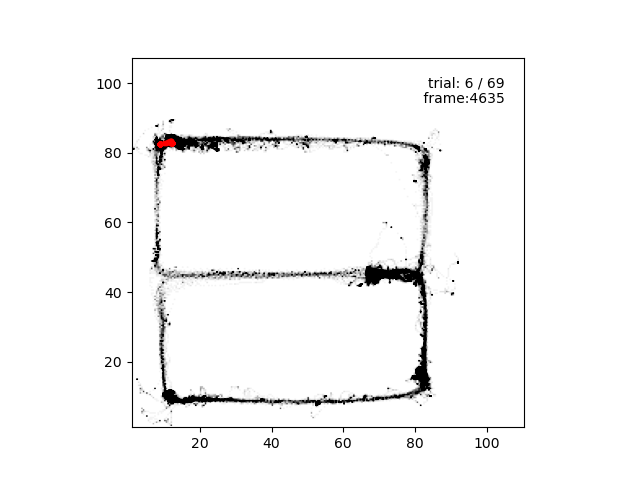

In [207]:
%matplotlib notebook
import animate_helper as ah
reload(ah)
save_dir = os.path.join(data_dir_full,'py_figures','behavior')
dosave = False
fig,ax,ani=ah.animate_movement_in_maze(sub_beh_df[['x','y']].values.T,sub_beh_df['x'],sub_beh_df['y'],hist2d_kws={'bins':200},ax_kws={},fig=None,ax=None,
                                    animate_kws={},dosave=dosave,
                                    do_plot_background_maze=True,
                                    trial_l = trial_l,
                                    save_dir=save_dir
                                )

<IPython.core.display.Javascript object>


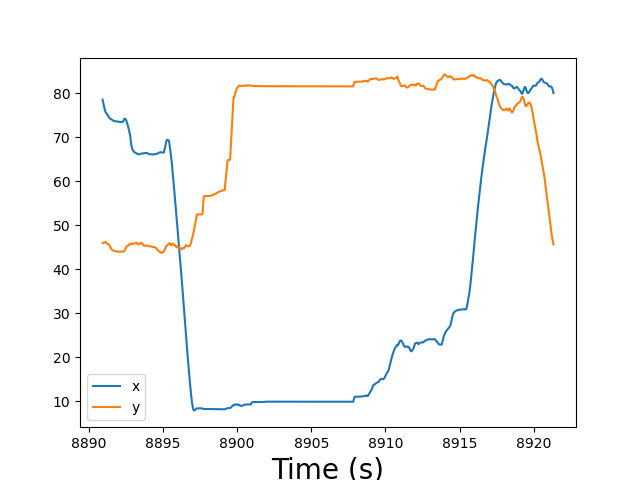

<AxesSubplot:xlabel='Time (s)'>

In [202]:
beh_df.query('trial==35')[['x','y']].plot()

<IPython.core.display.Javascript object>


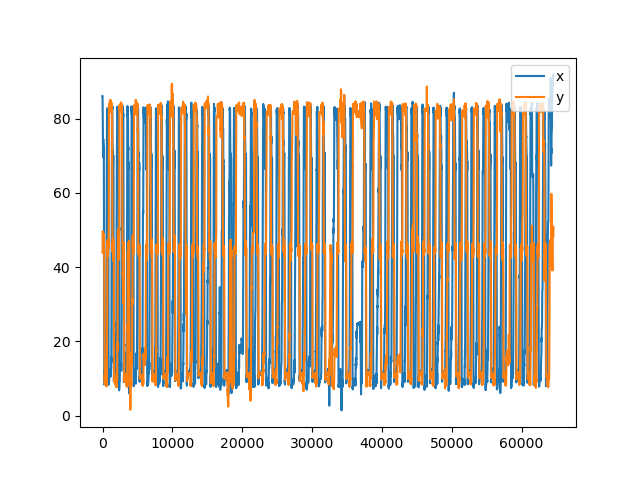

<AxesSubplot:>

In [201]:
sub_beh_df[['x','y']].plot()

In [159]:
ax.plot(xy_sampled_d[0,0][:,0],xy_sampled_d[0,0][:,1])
ax.plot(xy_sampled_d[0,1][:,0],xy_sampled_d[0,1][:,1])

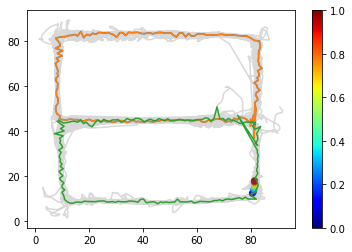

In [160]:
fig

In [168]:
xy_one_seg=xy_sampled_d[0,0][segment_d[0,0]==1]

In [169]:
np.polyfit(xy_one_seg[:,0],xy_one_seg[:,1],deg=1)

array([ 2.03808927, 46.0716703 ])

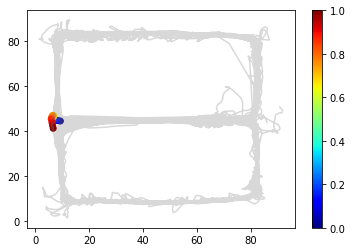

In [62]:
plt.plot(sub_beh_df['x'],sub_beh_df['y'],c='grey',alpha=0.3)
# for sl in block_slices_merged_long_stationary_radial:
#     sub_beh_df_slice=sub_beh_df.loc[sl[0]:sl[1]]
#     plt.plot(sub_beh_df_slice['x'],sub_beh_df_slice['y'],c='r')
colors = np.arange(one_chunk['x'].shape[0])
cmap = plt.get_cmap('jet')
norm = plt.Normalize(min(colors), max(colors))
plt.scatter(one_chunk['x'],one_chunk['y'],c=cmap(norm(colors)))
cbar = plt.colorbar(cm.ScalarMappable(cmap=cmap))



In [20]:
block_slices_merged_long_stationary_radial

array([[  119,   136],
       [  150,   191],
       [  988,  1239],
       [ 1478,  1568],
       [ 2276,  2327],
       [ 2870,  2956],
       [ 3639,  3651],
       [ 3794,  3818],
       [ 3895,  4015],
       [ 4295,  4324],
       [ 5891,  6167],
       [ 6288,  6351],
       [ 6982,  7063],
       [ 8559,  8637],
       [ 9727,  9978],
       [12926, 12986],
       [13519, 13538],
       [13608, 13650],
       [14442, 14484],
       [15319, 15413],
       [16342, 16697],
       [17495, 17983],
       [17997, 18017],
       [18341, 18417],
       [20470, 20550],
       [20678, 20971],
       [21152, 21198],
       [22196, 22264],
       [24415, 24768],
       [25188, 25234],
       [25978, 26053],
       [26188, 26601],
       [27444, 27520],
       [28831, 28843],
       [28872, 28955],
       [29549, 29701],
       [31392, 31475],
       [31956, 32750],
       [33892, 34330],
       [34555, 34624],
       [36264, 36379],
       [36407, 37148],
       [38878, 39242],
       [407

In [19]:
block_slices_merged_long_stationary_radial

array([[  119,   136],
       [  150,   191],
       [  988,  1239],
       [ 1478,  1568],
       [ 2276,  2327],
       [ 2870,  2956],
       [ 3639,  3651],
       [ 3794,  3818],
       [ 3895,  4015],
       [ 4295,  4324],
       [ 5891,  6167],
       [ 6288,  6351],
       [ 6982,  7063],
       [ 8559,  8637],
       [ 9727,  9978],
       [12926, 12986],
       [13519, 13538],
       [13608, 13650],
       [14442, 14484],
       [15319, 15413],
       [16342, 16697],
       [17495, 17983],
       [17997, 18017],
       [18341, 18417],
       [20470, 20550],
       [20678, 20971],
       [21152, 21198],
       [22196, 22264],
       [24415, 24768],
       [25188, 25234],
       [25978, 26053],
       [26188, 26601],
       [27444, 27520],
       [28831, 28843],
       [28872, 28955],
       [29549, 29701],
       [31392, 31475],
       [31956, 32750],
       [33892, 34330],
       [34555, 34624],
       [36264, 36379],
       [36407, 37148],
       [38878, 39242],
       [407

In [ ]:
# define peri


<AxesSubplot:>

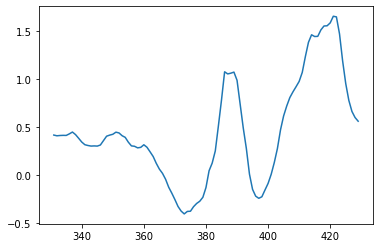

In [155]:
sub_beh_df.loc[331:429]['coord_off'].plot()

In [156]:
block_slices_merged_long_stationary_radial

array([[  119,   136],
       [  150,   191],
       [  988,  1239],
       [ 1478,  1568],
       [ 2276,  2327],
       [ 2870,  2956],
       [ 3639,  3651],
       [ 3794,  3818],
       [ 3895,  4015],
       [ 4295,  4324],
       [ 5891,  6167],
       [ 6288,  6351],
       [ 6982,  7063],
       [ 8559,  8637],
       [ 9727,  9978],
       [12926, 12986],
       [13519, 13538],
       [13608, 13650],
       [14442, 14484],
       [15319, 15413],
       [16342, 16697],
       [17495, 18017],
       [18341, 18417],
       [20470, 20550],
       [20678, 20971],
       [21152, 21198],
       [22196, 22264],
       [24415, 24768],
       [25188, 25234],
       [25978, 26053],
       [26188, 26601],
       [27444, 27520],
       [28831, 28843],
       [28872, 28955],
       [29549, 29701],
       [31392, 31475],
       [31956, 32750],
       [33892, 34330],
       [34555, 34624],
       [36264, 36379],
       [36407, 37148],
       [38878, 39242],
       [40796, 40820],
       [408

In [8]:
reload(dpp)
beh_df = dpp.get_multi_maze_behavior_df(behavior,transition_cov_scale=0.1)

/mnt/home/szheng/projects/util_code/data_prep_pyn.py:299: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  def prep_roman_data(behavior,cell_metrics,**kwargs):
/mnt/home/szheng/projects/util_code/data_prep_pyn.py:594: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  #     find the lin corresponding to corners/turns in t-maze, assuming those are where the animals spend more times
/mnt/home/szheng/projects/util_code/data_prep_pyn.py:566: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

<AxesSubplot:xlabel='Time (s)'>

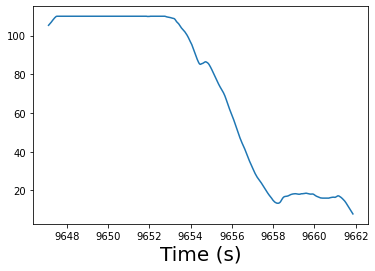

In [470]:
beh_df.query('task_index==1').query('trial==4')['lin'].plot()

<AxesSubplot:xlabel='Time (s)'>

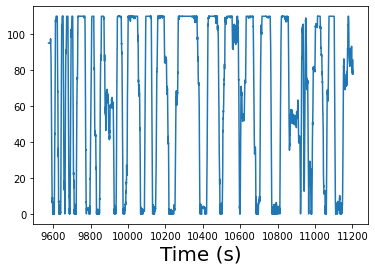

In [472]:
beh_df.query('task_index==1')['lin'].plot()

<AxesSubplot:xlabel='Time (s)'>

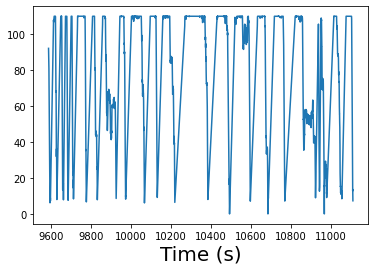

In [473]:
beh_df.query('task_index==1&direction==0')['lin'].plot()

In [586]:
sub=beh_df.query('task_index==1&direction==1&speed_kalman>=0')
np.sign(sub['v_kalman']).value_counts()

 1.0    12037
-1.0     7093
 0.0      277
Name: v_kalman, dtype: int64

In [7]:
def sign_count_return_larger_ind(x):
    sgn = np.sign(x).value_counts().sort_values(ascending=False).index[0]
    return sgn
direction_to_sign = beh_df.query('task_index==1').groupby('direction')['v_kalman'].apply(lambda x:sign_count_return_larger_ind(x))


direction
0   -1.0
1    1.0
Name: v_kalman, dtype: float64

In [569]:
beh_df.query('task_index==1&trial==1')

,lin,x,y,trial,task_index,task,speed_kalman,vx_kalman,vy_kalman,v_kalman,visitedArm,direction,correct,v,trial_type,v_kalman_aligned
Time (s),,,,,,,,,,,,,,,,
9596.809900,6.997399,15.723712,103.082595,1.0,1,linearMaze,1.497780,NaN,NaN,1.497780,NaN,1,1.0,1.496308,"(1, 1)",NaN
9596.843233,3.476695,15.073706,106.596226,1.0,1,linearMaze,0.487464,NaN,NaN,-0.487464,NaN,1,1.0,-0.488852,"(1, 1)",NaN
9596.876567,4.114823,15.225061,105.953827,1.0,1,linearMaze,1.551946,NaN,NaN,-1.551946,NaN,1,1.0,-1.553227,"(1, 1)",NaN
9596.909933,4.488898,15.412616,105.573171,1.0,1,linearMaze,2.085251,NaN,NaN,-2.085251,NaN,1,1.0,-2.086566,"(1, 1)",NaN
9596.943267,1.672334,15.049818,108.397445,1.0,1,linearMaze,3.775988,NaN,NaN,-3.775988,NaN,1,1.0,-3.777331,"(1, 1)",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9612.013800,104.256851,10.272056,7.317840,1.0,1,linearMaze,27.324805,NaN,NaN,27.324805,NaN,1,1.0,27.318278,"(1, 1)",NaN
9612.047133,104.916983,10.167330,6.665816,1.0,1,linearMaze,27.098440,NaN,NaN,27.098440,NaN,1,1.0,27.091787,"(1, 1)",NaN
9612.080467,105.511102,10.057413,6.096929,1.0,1,linearMaze,26.829807,NaN,NaN,26.829807,NaN,1,1.0,26.823187,"(1, 1)",NaN


<AxesSubplot:xlabel='Time (s)'>

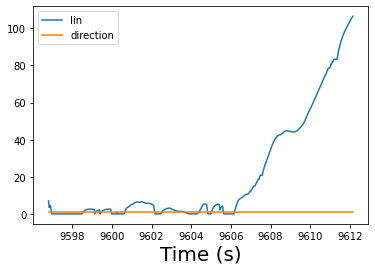

In [570]:
sub=beh_df.query('task_index==1&trial==1')
sub[['lin','direction']].plot()


In [533]:
lin=beh_df.loc[beh_df['task_index']==1]['lin'].values
xy=np.stack([lin,np.zeros_like(lin)],axis=1)
xy_smth=dpp.get_speed_kalman(xy)


In [534]:
xy_smth[:,2]

array([0.       , 0.       , 0.       , ..., 7.3121783, 7.5936386,
       7.8352081])

<AxesSubplot:xlabel='Time (s)'>

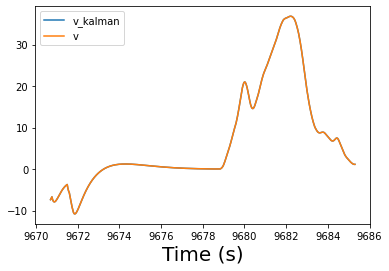

In [14]:
beh_df.query('task_index==1&trial==6')[['v_kalman','v']].plot()


<AxesSubplot:xlabel='Time (s)'>

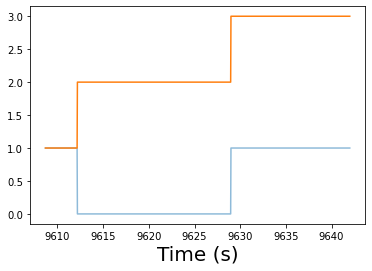

In [560]:
(beh_df.query('task_index==1')['direction']==1).iloc[1000:2000].astype(int).plot(alpha=0.5)
beh_df.query('task_index==1').iloc[1000:2000]['trial'].plot()

<AxesSubplot:xlabel='Time (s)'>

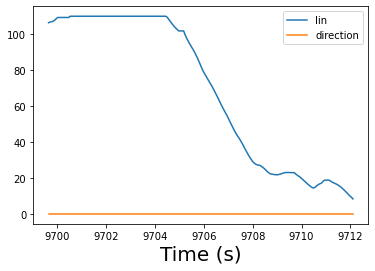

In [480]:
beh_df.query('task_index==1').query('trial==8')[['lin','direction']].plot()

In [4]:
from scipy.interpolate import interp1d

In [422]:
reload(dpp)
v_dir_d = dpp.get_v_direction(corners_d,thresh = 5.)

In [428]:
gpb = beh_df.groupby('trial_type')
for tt, val in gpb:
    v_dir = v_dir_d[tt]
    val_xy_to_sample_dist = cdist(val[['x','y']].values,xy_sampled_d[tt])
    inds = np.argmin(val_xy_to_sample_dist,axis=1)
    seg_l = segment_d[tt][inds]
    x_sign_l = v_dir.loc[seg_l,'x_sign'].values
    y_sign_l = v_dir.loc[seg_l,'y_sign'].values
    
    v_aligned = val['vx_kalman'] * x_sign_l + val['vy_kalman'] * y_sign_l # assuming sign: one +-1, the other 0
    aligned = np.sign(v_aligned)
    v_kalman = val['speed_kalman'] * aligned
    beh_df.loc[val.index,'v_kalman'] = v_kalman
    beh_df.loc[val.index,'v_kalman_aligned'] = v_aligned
    

<AxesSubplot:xlabel='Time (s)'>

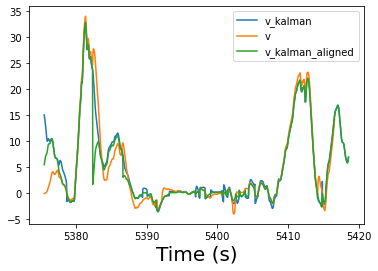

In [466]:
tr=2
beh_df.query('task_index==0').query('trial==@tr')[['v_kalman','v','v_kalman_aligned']].plot()


In [405]:
aligned

Time (s)
6644.342033     1.758613
6644.375367   -10.957039
6644.408700   -10.897390
6644.442067   -10.939547
6644.475400   -11.010290
                 ...    
8438.263767    -6.393860
8438.297133    -6.144988
8438.330467    -5.980533
8438.363800    -5.837306
8438.397133    -5.680013
Length: 19937, dtype: float64

In [ ]:
inds

In [393]:
from scipy.spatial.distance import pdist, cdist, squareform

In [394]:
val_xy_to_sample_dist = cdist(val[['x','y']].values,xy_sampled_d[tt])
inds = np.argmin(val_xy_to_sample_dist,axis=1)

In [395]:
segment_d[tt][inds]

array([0., 3., 3., ..., 0., 0., 0.])

In [ ]:
x_sign,y_sign = 

<AxesSubplot:xlabel='Time (s)'>

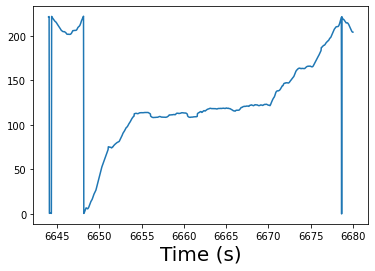

In [281]:
beh_df.loc[beh_df.index.to_series().between(6644,6680)]['lin'].plot()

<AxesSubplot:xlabel='Time (s)'>

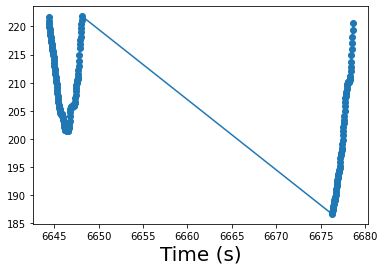

In [282]:
val.loc[ma].query('trial==1')['lin'].plot(marker='o')

In [266]:
aligned

Time (s)
6644.375367   -10.957039
6644.408700   -10.897390
6644.442067   -10.939547
6644.475400   -11.010290
6644.508733   -11.108341
                 ...    
8438.263767    -1.032613
8438.297133    -1.275685
8438.330467    -1.495740
8438.363800    -1.659392
8438.397133    -1.784106
Length: 3925, dtype: float64

In [211]:
v_direction_df

,lin_st,lin_end,x_sign,y_sign
0,0.100000,75.894909,-1.0,0.0
1,75.894909,110.448471,0.0,-1.0
2,110.448471,186.243380,1.0,0.0
3,186.243380,221.911572,0.0,1.0


In [193]:
corners

,x,y,lin
0,82.747642,45.513678,0.100000
1,9.326830,45.513678,75.894909
2,9.326830,9.581378,110.448471
3,82.747642,9.581378,186.243380
4,82.747642,45.513678,221.911572


In [191]:
ma = (beh_df[['vx_kalman','vy_kalman']].abs()>5).all(axis=1)


In [192]:
beh_df.loc[ma]

,lin,x,y,trial,task_index,task,speed,speed_kalman,vx_kalman,vy_kalman,visitedArm,direction,correct,v,trial_type
Time (s),,,,,,,,,,,,,,,
6615.501367,79.150497,10.040833,49.238081,0.0,0,alternation,9.421928,9.401326,-7.841990,5.185375,0.0,0,NaN,14.734165,"(0, 0.0)"
6615.534733,79.570687,9.960932,49.686944,0.0,0,alternation,9.371700,8.984851,-6.893705,5.762325,0.0,0,NaN,14.468684,"(0, 0.0)"
6615.568067,79.990877,9.997016,50.145654,0.0,0,alternation,9.336875,8.738544,-6.027881,6.326674,0.0,0,NaN,14.216369,"(0, 0.0)"
6615.601400,80.411067,10.141921,50.545882,0.0,0,alternation,9.316824,8.584911,-5.178255,6.847363,0.0,0,NaN,13.976589,"(0, 0.0)"
6648.376400,5.635969,75.464345,46.036038,1.0,0,alternation,12.815335,19.094285,-5.544349,18.271615,1.0,1,1.0,0.263097,"(0, 1.0)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8429.328167,13.687353,67.603393,53.522379,34.0,0,alternation,4.050115,12.038844,-6.077685,10.392088,1.0,1,1.0,NaN,"(0, 1.0)"
8429.361533,13.687353,67.569477,53.558518,34.0,0,alternation,3.964070,11.907709,-5.940087,10.320315,1.0,1,1.0,NaN,"(0, 1.0)"
8429.394867,13.597893,67.634154,53.499879,34.0,0,alternation,3.876426,11.622403,-5.725586,10.114243,1.0,1,1.0,NaN,"(0, 1.0)"


In [180]:
corners_d

x          y         lin
0 0.0 0  81.755802  44.997066    0.100000
      1   9.517683  44.997066   74.780202
      2   9.517683  82.666278  111.562988
      3  81.755802  82.666278  184.013929
      4  81.755802  44.997066  221.911345
  1.0 0  82.747642  45.513678    0.100000
      1   9.326830  45.513678   75.894909
      2   9.326830   9.581378  110.448471
      3  82.747642   9.581378  186.243380
      4  82.747642  45.513678  221.911572

In [165]:
import itertools
# get corners both trial types
gpb=beh_df.groupby('trial_type')
n_lin = 200
corners_d = {}
for tt, val in gpb:
    val = val.query('speed_kalman>10')
    lin_one = val['lin'].values
    lin_to_xy_func = interp1d(lin_one,val[['x','y']].values,axis=0)
    lin_vals = np.linspace(lin_one.min()+0.1,lin_one.max(),n_lin)
    xy_sampled = lin_to_xy_func(lin_vals)
    x_bounds = hist_find_peaks(xy_sampled[:,0],n_peaks=2)
    y_bounds = hist_find_peaks(xy_sampled[:,1],n_peaks=2)
    xy_corners = np.array(list(itertools.product(x_bounds,y_bounds)))
    lin_corners = []
    xyc_l = []
    lc_l = []
    for xyc in xy_corners:
        lin_c = map_xy_to_lin(xyc,lin_vals,xy_sampled)
        lin_corners.append(lin_c)
        for lc in lin_c:
            xyc_l.append(xyc)
            lc_l.append(lc)
    xyc_l = np.array(xyc_l)
    lc_l = np.array(lc_l)
    corners = np.concatenate([xyc_l,lc_l[:,None]],axis=1)
    corners = pd.DataFrame(corners,columns=['x','y','lin'])
    corners = corners.sort_values('lin').reset_index(drop=True)
    corners_d[tt] = corners
corners_d = pd.concat(corners_d)

In [149]:
xyc

array([81.75580236, 82.66627817])

In [166]:
corners_d

x          y         lin
0 0.0 0  81.755802  44.997066    0.100000
      1   9.517683  44.997066   74.780202
      2   9.517683  82.666278  111.562988
      3  81.755802  82.666278  184.013929
      4  81.755802  44.997066  221.911345
  1.0 0  82.747642  45.513678    0.100000
      1   9.326830  45.513678   75.894909
      2   9.326830   9.581378  110.448471
      3  82.747642   9.581378  186.243380
      4  82.747642  45.513678  221.911572

In [154]:
corners_d

x          y         lin
0 0.0 0  81.755802  44.997066    0.100000
      3   9.517683  44.997066   74.780202
      4   9.517683  82.666278  111.562988
      2  81.755802  82.666278  184.013929
      1  81.755802  44.997066  221.911345
  1.0 3  82.747642  45.513678    0.100000
      1   9.326830  45.513678   75.894909
      0   9.326830   9.581378  110.448471
      2  82.747642   9.581378  186.243380
      4  82.747642  45.513678  221.911572

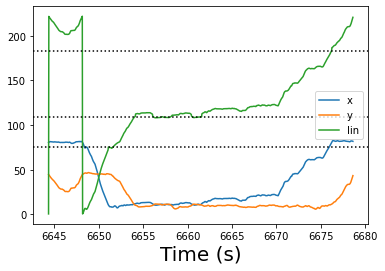

In [136]:
ax=beh_df.query('trial==1')[['x','y','lin']].plot()
ax.axhline(76,c='k',linestyle=':')
ax.axhline(109,c='k',linestyle=':')
ax.axhline(183,c='k',linestyle=':')

In [120]:
corners

,x,y,lin
3,80.889355,45.273757,0.0
1,9.660257,45.273757,34.0
0,9.660257,9.368587,49.0
2,80.889355,9.368587,82.0
4,80.889355,45.273757,99.0


In [107]:
lin_corners

[49, 34, 82, 0, 99]

In [104]:
49 * 2.2

107.80000000000001

In [43]:
xy_sampled

array([[80.77497299, 44.82816383],
       [78.66736788, 45.06985779],
       [76.49598353, 45.8575914 ],
       [74.29172142, 45.95551738],
       [72.13063855, 45.49171305],
       [69.97208713, 50.16554429],
       [67.77349981, 50.30048043],
       [65.61898847, 46.06285933],
       [63.4823935 , 44.88567733],
       [61.34418427, 45.55466141],
       [59.16902993, 45.83145375],
       [56.9967293 , 45.81328866],
       [54.84887146, 45.71284875],
       [52.68295313, 45.41044032],
       [50.50525344, 45.9717566 ],
       [48.3242653 , 44.88118635],
       [46.17065804, 44.60920767],
       [44.04665679, 46.02075963],
       [41.84241261, 45.12648857],
       [39.71848721, 44.74647191],
       [37.55445274, 46.00234803],
       [35.38905382, 45.56945475],
       [33.20233878, 45.2931255 ],
       [31.02114285, 45.23008301],
       [28.86163552, 45.58150859],
       [26.74477586, 45.52457493],
       [24.56826435, 45.43484451],
       [22.42510492, 44.61473663],
       [20.24561547,

In [42]:
xy_corners[-1]

array([80.88935519, 45.27375673])

In [38]:
lin_corners

[109.88552560991843, 76.22674322503745, 184.87058024706803, 86.66687962433691]

In [30]:
xyc

(9.726067499581582, 44.581262403084835)

In [27]:
xy_sampled

array([[80.77497299, 44.82816383],
       [78.66736788, 45.06985779],
       [76.49598353, 45.8575914 ],
       [74.29172142, 45.95551738],
       [72.13063855, 45.49171305],
       [69.97208713, 50.16554429],
       [67.77349981, 50.30048043],
       [65.61898847, 46.06285933],
       [63.4823935 , 44.88567733],
       [61.34418427, 45.55466141],
       [59.16902993, 45.83145375],
       [56.9967293 , 45.81328866],
       [54.84887146, 45.71284875],
       [52.68295313, 45.41044032],
       [50.50525344, 45.9717566 ],
       [48.3242653 , 44.88118635],
       [46.17065804, 44.60920767],
       [44.04665679, 46.02075963],
       [41.84241261, 45.12648857],
       [39.71848721, 44.74647191],
       [37.55445274, 46.00234803],
       [35.38905382, 45.56945475],
       [33.20233878, 45.2931255 ],
       [31.02114285, 45.23008301],
       [28.86163552, 45.58150859],
       [26.74477586, 45.52457493],
       [24.56826435, 45.43484451],
       [22.42510492, 44.61473663],
       [20.24561547,

In [25]:
y_bounds

array([ 9.36858743, 45.27375673])

(array([18.,  4.,  4.,  2.,  4.,  4.,  4.,  2.,  4.,  4.,  2.,  4.,  4.,
         4.,  2.,  4.,  4.,  2.,  4., 20.]),
 array([ 8.48917002, 12.17655016, 15.86393029, 19.55131043, 23.23869056,
        26.9260707 , 30.61345083, 34.30083096, 37.9882111 , 41.67559123,
        45.36297137, 49.0503515 , 52.73773164, 56.42511177, 60.1124919 ,
        63.79987204, 67.48725217, 71.17463231, 74.86201244, 78.54939258,
        82.23677271]),
 <BarContainer object of 20 artists>)

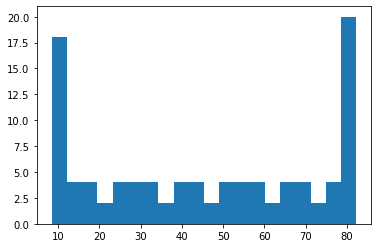

In [17]:
plt.hist(xy_sampled[:,0],bins=20)

In [12]:
dpp.kde_findpeak(xy_sampled[:,0],height=0.01)

(array([16.89079565, 75.702175  ]),
 array([0.01019492, 0.01060375, 0.01096768, 0.01128332, 0.01154841,
        0.01176182, 0.01192359, 0.01203487, 0.01209787, 0.01211571,
        0.0120923 , 0.01203219, 0.01194035, 0.01182203, 0.01168256,
        0.01152719, 0.01136095, 0.01118851, 0.0110141 , 0.01084142,
        0.01067362, 0.01051325, 0.01036228, 0.01022216, 0.0100938 ,
        0.00997767, 0.00987385, 0.0097821 , 0.00970192, 0.00963262,
        0.00957339, 0.00952332, 0.00948149, 0.009447  , 0.00941897,
        0.00939662, 0.00937923, 0.00936621, 0.00935705, 0.0093514 ,
        0.00934902, 0.00934977, 0.00935368, 0.00936089, 0.00937165,
        0.00938637, 0.00940553, 0.00942977, 0.0094598 , 0.00949642,
        0.00954048, 0.0095929 , 0.00965455, 0.0097263 , 0.00980889,
        0.00990295, 0.01000886, 0.01012675, 0.01025639, 0.01039716,
        0.01054794, 0.01070711, 0.01087251, 0.01104137, 0.01121038,
        0.01137566, 0.01153286, 0.01167719, 0.01180361, 0.01190686,
        0.01

In [127]:
curv = np.linalg.norm(np.diff(np.diff(xy_sampled,axis=0),axis=0),axis=1)

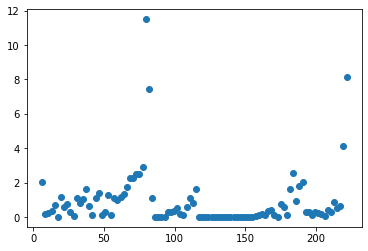

In [128]:
plt.scatter(lin_vals[2:],curv)

In [100]:
import pykalman
from pykalman import KalmanFilter

In [133]:
reload(dpp)
xy_sampled_smth=dpp.get_speed_kalman(xy_sampled,dt=1.,transition_cov_scale=10.)

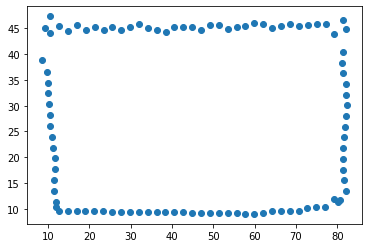

In [134]:
plt.scatter(xy_sampled_smth[:,0],xy_sampled_smth[:,1])

In [167]:
from sklearn.mixture import GaussianMixture

In [176]:
gmm=GaussianMixture(n_components=4)
clust = gmm.fit_predict(xy_sampled)


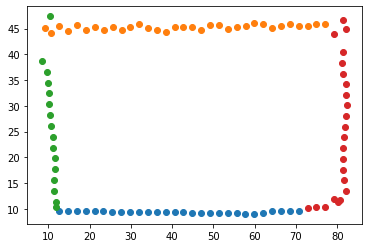

In [179]:
fig,ax=plt.subplots()
for ii,c in enumerate(range(4)):
    ma = clust==c
    ax.scatter(xy_sampled[ma,0],xy_sampled[ma,1],c=f'C{ii}')

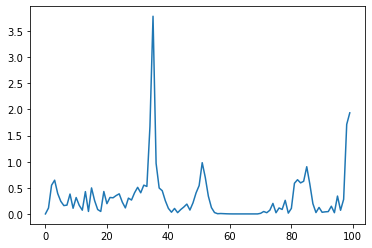

In [137]:
plt.plot(np.linalg.norm(xy_sampled_smth[:,[4,5]],axis=1))

In [ ]:
plt.scatter(xy_sampled_smth[:,0],xy_sampled_smth[:,1])

In [101]:
KalmanFilter

pykalman.standard.KalmanFilter

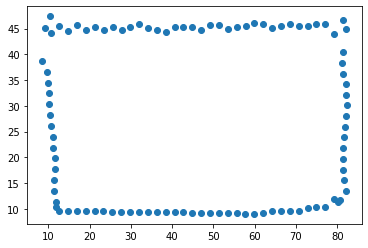

In [129]:
plt.scatter(xy_sampled[:,0],xy_sampled[:,1])

In [85]:
plt.plot(,curv)

array([        nan,  4.19787335,  5.11529472,  2.11216063,  1.90248055,
        0.76202926,  2.95816168,  0.74872729,  1.82646969,  1.01974548,
        1.05672803,  0.79503369,  0.28474271,  0.2272161 ,  0.78693374,
        0.48861956,  0.25161672,  0.7455433 ,  0.16814424,  0.54544762,
        0.18563256,  0.45664242,  0.29953299,  0.23469108,  1.97332377,
        2.29200297,  0.41182168,  1.14395782,  1.74488951,  0.63711703,
        1.05221222,  1.95982366,  4.55563498,  8.01708009,  3.53802735,
        4.61523024,  3.14867878,  0.18755319,  1.33072856,  1.26696244,
        0.26335667,  0.20372036,  3.95256258,  8.28665902,  6.04021086,
        2.29573731,  0.89564207,  0.08475184,  2.10100563,  1.41305613,
        0.70631948,  0.52322921,  2.13747065,  3.233062  ,  2.91842792,
        3.48336919,  4.06000098,  2.54404815,  2.15176492,  2.17512609,
        0.40823054,  1.01610311,  0.93666379,  0.23438567,  0.60056627,
        0.92635834,  2.29363864,  5.39187922,  7.47980866,  3.45

In [119]:
xy_sampled_smth

array([[ 8.07749730e+01,  4.48281638e+01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 7.94337419e+01,  4.49819723e+01, -1.14956099e+00,
         1.31828278e-01, -3.83186997e-01,  4.39427594e-02],
       [ 7.68124130e+01,  4.57145347e+01, -2.62592157e+00,
         6.69991300e-01, -8.14699064e-01,  2.39027977e-01],
       [ 7.41978410e+01,  4.60559808e+01, -3.11580443e+00,
         5.61426368e-01, -6.97967264e-01,  1.14110731e-01],
       [ 7.18374187e+01,  4.57398593e+01, -3.04908199e+00,
         2.83950605e-02, -4.59832505e-01, -8.74180886e-02],
       [ 6.96213005e+01,  4.90635567e+01, -2.85756432e+00,
         1.98717751e+00, -2.84805264e-01,  4.62425677e-01],
       [ 6.74393492e+01,  5.05851249e+01, -2.69830334e+00,
         2.07132775e+00, -1.80875058e-01,  3.73893292e-01],
       [ 6.52978084e+01,  4.83117428e+01, -2.56599377e+00,
         2.52321073e-01, -1.16229400e-01, -7.87517309e-02],
       [ 6.31822286e+01,  4.62363783e+01, -2.461

In [49]:
reload(dpp)
gpb=beh_df.groupby('trial_type')
lin_d_d = {}
lin_val_left_d={}
for tt, val in gpb:
    xy = val[['x','y']].values
    lin = val['lin'].values
    lin_d,lin_val_left=dpp.find_t_maze_stoppoints_lin(xy,lin,height=0.005)
    lin_val_left_d[tt] = lin_val_left
    lin_d_d[tt] = lin_d
#     for beg,end in zip(lin_val_left[:-1],lin_val_left[1:]):
#         ma=(val['lin']>=beg) & (val['lin']<=end)
#         x_sign=np.sign(val.loc[ma,'vx_kalman']) * (val.loc[ma,'vx_kalman'] > 5)
#         y_sign=np.sign(val.loc[ma,'vy_kalman']) * (val.loc[ma,'vy_kalman'] > 5)
    

[11.87713279 81.26510538]


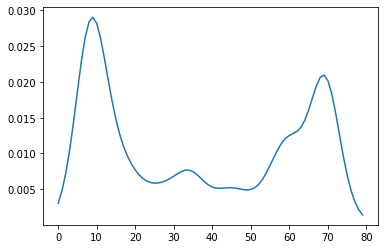

In [52]:
reload(dpp)
pdf_peaks,pdf=dpp.kde_findpeak(xy[:,0],height=0.01)
print(pdf_peaks)
plt.plot(pdf)

In [50]:
lin_d_d[0,0]

{(11.149371981101002, 45.21395329585653): 72.38517728870688,
 (11.149371981101002, 63.373376625842255): 92.78723647388853,
 (11.149371981101002, 82.18135078904174): 112.82244766024652,
 (27.743569194094515, 45.21395329585653): 55.043993098384234,
 (27.743569194094515, 63.373376625842255): 0.0,
 (27.743569194094515, 82.18135078904174): 129.47975113106406,
 (44.337766407088026, 45.21395329585653): 37.85058563796954,
 (44.337766407088026, 63.373376625842255): 0.0,
 (44.337766407088026, 82.18135078904174): 146.05663731687048,
 (80.84500027567375, 45.21395329585653): 0.0,
 (80.84500027567375, 63.373376625842255): 203.1301931566648,
 (80.84500027567375, 82.18135078904174): 182.81751579355478}

In [51]:
lin_d_d[0,1]

{(11.877132788801095, 9.734394648237945): 111.96934471509911,
 (11.877132788801095, 45.829492065585086): 71.71762722689391,
 (40.78878803545808, 9.734394648237945): 142.2600500597047,
 (40.78878803545808, 45.829492065585086): 41.46362760561127,
 (53.50991634398716, 9.734394648237945): 155.25475656233596,
 (53.50991634398716, 45.829492065585086): 28.402929069054537,
 (81.26510538077787, 9.734394648237945): 184.2885794362889,
 (81.26510538077787, 45.829492065585086): 221.08498845285322}

In [ ]:
def get_signed_v_tmaze(beh_df,lin_stoppoints,v_thresh=2.):
    '''
    beh_df already has vx_kalman, vy_kalman
    within a segment marked by lin_stoppoints, find the dominant sign, flip the speed_kalman if sign doesn't match
    '''
    gpb=beh_df.groupby('trial_type')
    for tt, val in gpb:
        for beg,end in zip(lin_stoppoints[:-1],lin_stoppoints[1:]):
            ma=(val['lin']>=beg) & (val['lin']<=end)
            x_sign=np.sign(val.loc[ma,'vx_kalman']) * (val.loc[ma,'vx_kalman'] > v_thresh)
            y_sign=np.sign(val.loc[ma,'vy_kalman']) * (val.loc[ma,'vy_kalman'] > v_thresh)
    

In [16]:
lin_d

{(10.576815747676642, 10.474496767290397): 111.02171044796104,
 (10.576815747676642, 44.93868710675155): 72.266279775753,
 (10.576815747676642, 82.73812167261217): 113.08091210146345,
 (81.62166673762397, 10.474496767290397): 185.64124578911384,
 (81.62166673762397, 44.93868710675155): 221.22987741961606,
 (81.62166673762397, 82.73812167261217): 184.25028725613362}

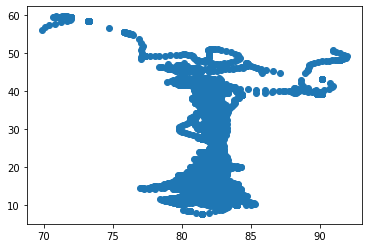

In [15]:
plt.scatter(val.loc[ma]['x'],val.loc[ma]['y'])

In [74]:
val.loc[ma,'x'].max()

91.93462897810019

In [72]:
val.loc[ma,'y'].max()

59.776451392075074

<AxesSubplot:xlabel='Time (s)'>

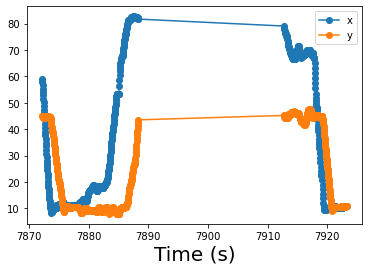

<Figure size 432x288 with 0 Axes>

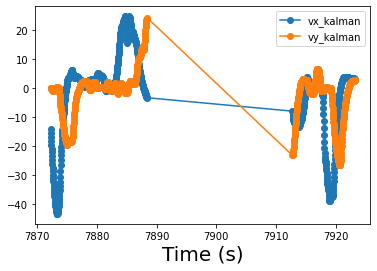

In [90]:
val[['x','y']].iloc[200:1000].plot(marker='o')
plt.figure()
val[['vx_kalman','vy_kalman']].iloc[200:1000].plot(marker='o')

<AxesSubplot:xlabel='Time (s)'>

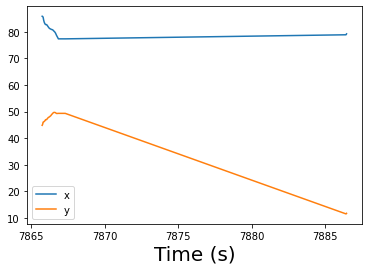

In [82]:
val.loc[ma][['x','y' ]].iloc[:50].plot()

<AxesSubplot:>

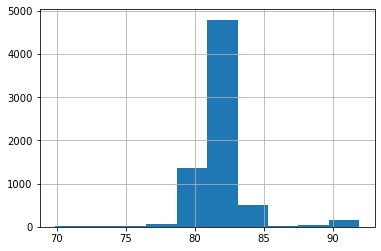

In [68]:
val.loc[ma,'x'].hist()

<AxesSubplot:>

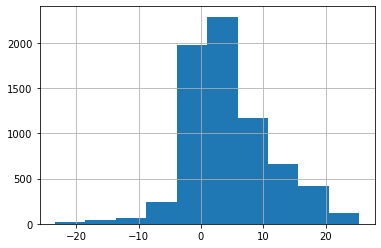

In [65]:
val.loc[ma,'vy_kalman'].hist()

<AxesSubplot:>

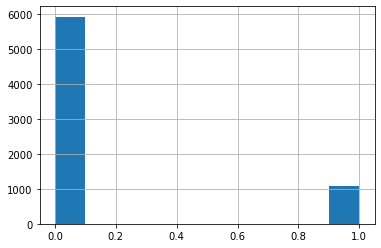

In [62]:
x_sign.hist()

<AxesSubplot:>

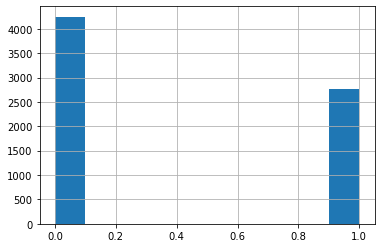

In [63]:
y_sign.hist()

In [30]:
for beg,end in zip(lin_val_left[:-1],lin_val_left[1:]):
    ma=(lin>=beg) & (lin<=end)
    np.sign(xy_smth[ma,2])

In [38]:
spk_beh_df['vx_kalman']=xy_smth[:,2]
spk_beh_df['vy_kalman']=xy_smth[:,3]

ValueError: Length of values (64796) does not match length of index (64576)

In [36]:
gpb = spk_beh_df.groupby('trial_type')
for tt, val in gpb:
    for beg,end in zip(lin_val_left[:-1],lin_val_left[1:]):
        ma=(val['lin']>=beg) & (val['lin']<=end)
        np.sign(xy_smth[ma,2])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 64796 but corresponding boolean dimension is 29664

(array([5928.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        4367.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

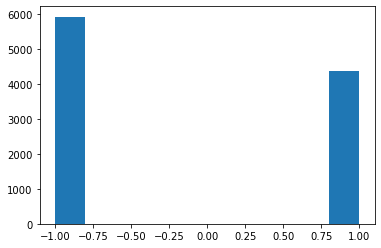

In [33]:
plt.hist(np.sign(xy_smth[ma,2]))